In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path
from shapely.geometry import Polygon, Point
import random

In [5]:

# ============================================================
# --- VORONOI HELPERS --- For the polygon generation 
# ============================================================

def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]


In [6]:
# ============================================================
# --- SIMULATION PARAMETERS ---
# ============================================================

WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8       # Number of districts
NUM_DOTS = 1000         # Number of voters
COLORS = ['red', 'blue', 'green'] # Parties
NUM_RUNS = 100           # Number of simulations

# ============================================================
# --- CREATE FIXED DISTRICT MAP (run once) ---
# ============================================================

points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

district_polygons = []
for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_polygons.append(None)
    else:
        district_polygons.append(sort_polygon(polygon))


In [7]:
# --- Compute area of a polygon ---
def polygon_area(polygon):
    poly = np.array(polygon)
    x = poly[:, 0]
    y = poly[:, 1]
    return 0.5 * abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

district_areas = [polygon_area(p) for p in district_polygons]
total_area = sum(district_areas)
area_weights = [a / total_area for a in district_areas]


# ============================================================
# --- Helper: sample a point inside a polygon ---
# ============================================================

def sample_point_in_polygon(polygon):
    poly = Polygon(polygon)
    minx, miny, maxx, maxy = poly.bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        if poly.contains(Point(x, y)):
            return x, y


In [8]:
# ============================================================
# --- Run election function ---
# ============================================================

def run_election():
    dots_x = []
    dots_y = []
    dots_colors = []

    district_counts = [
        {color: 0 for color in COLORS}
        for _ in district_polygons
    ]

    for i, polygon in enumerate(district_polygons):
        if polygon is None:
            continue

        n_voters = int(NUM_DOTS * area_weights[i])  # proportional to area
        for _ in range(n_voters):
            x, y = sample_point_in_polygon(polygon)
            color = np.random.choice(COLORS)
            dots_x.append(x)
            dots_y.append(y)
            dots_colors.append(color)
            district_counts[i][color] += 1

    return (
        np.array(dots_x),
        np.array(dots_y),
        np.array(dots_colors),
        district_counts
    )


In [9]:
# ============================================================
# --- FUNCTION: calculate proportional representation ---
# ============================================================

def calculate_PR(district_counts):
    results = []
    for district in district_counts:
        winner = max(district, key=district.get)
        winner_votes = district[winner]
        results.append((winner, winner_votes))
    return results


In [10]:
# ============================================================
# --- RUN ONE SIMULATION ---
# ============================================================

dots_x, dots_y, dots_colors, district_counts = run_election()
results = calculate_PR(district_counts)

for i, (winner, votes) in enumerate(results):
    print(f"District {i}: {winner} got {votes} votes")


District 0: red got 75 votes
District 1: red got 0 votes
District 2: red got 2 votes
District 3: red got 1 votes
District 4: red got 61 votes
District 5: green got 82 votes
District 6: red got 72 votes
District 7: blue got 66 votes


In [11]:
# ============================================================
# --- RUN MULTIPLE SIMULATIONS ---
# ============================================================

all_results = []
for run in range(NUM_RUNS):
    dots_x, dots_y, dots_colors, district_counts = run_election()
    all_results.append({
        'dots_x': dots_x,
        'dots_y': dots_y,
        'dots_colors': dots_colors
    })

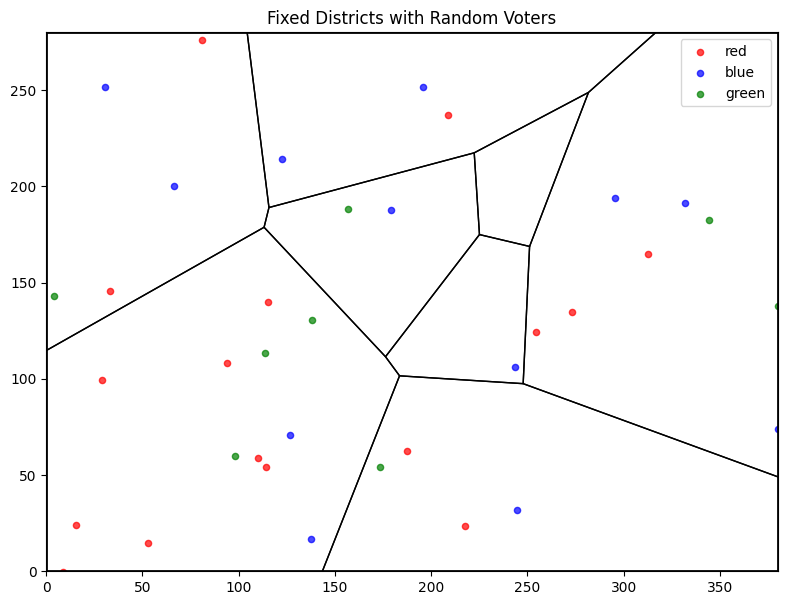

In [12]:
# ============================================================
# --- VISUALIZE ONE RUN ---
# ============================================================

run_to_show = 0
dots_x = all_results[run_to_show]['dots_x']
dots_y = all_results[run_to_show]['dots_y']
dots_colors = all_results[run_to_show]['dots_colors']

fig, ax = plt.subplots(figsize=(10,7))
for polygon in district_polygons:
    if polygon is not None:
        ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)

for color in COLORS:
    ax.scatter(dots_x[dots_colors==color], dots_y[dots_colors==color], c=color, label=color, s=20, alpha=0.7)

ax.plot([0, WIDTH, WIDTH, 0, 0], [0,0,HEIGHT,HEIGHT,0], color='black', linewidth=2)
ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Fixed Districts with Random Voters')
ax.legend()
plt.show()
